<a href="https://colab.research.google.com/github/ritikpathania/project/blob/main/sentimentAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
# Install necessary libraries
!pip install transformers
import numpy as np
import pandas as pd
import tensorflow as tf
from transformers import BertTokenizer, TFBertForSequenceClassification
from sklearn.model_selection import train_test_split
from google.colab import drive
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import matplotlib.pyplot as plt
import os
import zipfile
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers.schedules import ExponentialDecay


from google.colab import drive
drive.mount('/content/drive')

# Define the local path where you want to save the dataset zip file
local_zip_path = '/content/dataset.zip'

# Download the zip file from the Google Drive link
!gdown --id 1AAdD7d1TZSQE8mYFZI8_febLIwgznxhR -O "$local_zip_path"

# Specify the local directory where you want to extract the files
extraction_path = '/content/dataset'

# Create the extraction directory if it doesn't exist
os.makedirs(extraction_path, exist_ok=True)

# Unzip the dataset
with zipfile.ZipFile('/content/drive/MyDrive/archive.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/dataset')

# List the contents of the extraction directory to verify
extracted_files = os.listdir(extraction_path)
print(f"Extracted files: {extracted_files}")

# Load the dataset from the extracted directory
dataset_dir = '/content/dataset'
dataset_path = f"/content/dataset/Twitter_Data.csv"  # Replace with the actual CSV file
dataset = pd.read_csv(dataset_path)

# Split the dataset into training and validation data
train_data, val_data = train_test_split(dataset, test_size=0.2, random_state=42)

# Filter out non-empty and non-null text values
train_data = train_data.dropna(subset=['clean_text'])
train_data = train_data[train_data['clean_text'] != '']

# Map your labels to 0, 1, and 2
train_data['category'] = train_data['category'].map({-1: 0, 0: 1, 1: 2})
val_data['category'] = val_data['category'].map({-1: 0, 0: 1, 1: 2})

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1AAdD7d1TZSQE8mYFZI8_febLIwgznxhR
To: /content/dataset.zip
100% 20.9M/20.9M [00:00<00:00, 185MB/s]
Extracted files: ['__MACOSX', 'Twitter_Data.csv']


In [18]:
# Tokenize the text using BERT tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
X_train = tokenizer(list(train_data['clean_text']), padding='max_length', truncation=True, max_length=128, return_tensors='tf', return_token_type_ids=False)
X_val = tokenizer(list(val_data['clean_text']), padding='max_length', truncation=True, max_length=128, return_tensors='tf', return_token_type_ids=False)

# Convert to TensorFlow tensors
X_train = {key: tf.convert_to_tensor(X_train[key]) for key in X_train}
X_val = {key: tf.convert_to_tensor(X_val[key]) for key in X_val}

# Prepare labels
y_train = train_data['category'].to_numpy()
y_val = val_data['category'].to_numpy()

# Build the BERT-based model
model = TFBertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3)  # Three classes

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [19]:
# Compile the model with the appropriate loss function
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5), loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

initial_learning_rate = 2e-5
lr_schedule = ExponentialDecay(initial_learning_rate, decay_steps=1000, decay_rate=0.9)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=3, batch_size=20, callbacks=[early_stopping])

# Evaluate the model
loss, accuracy = model.evaluate(X_val, y_val)
print(f'Validation Loss: {loss:.4f}, Validation Accuracy: {accuracy:.4f}')

Epoch 1/3
40/40 [==============================] - 1370s 33s/step - loss: 1.0146 - accuracy: 0.5013 - val_loss: 1.0358 - val_accuracy: 0.5150
Epoch 2/3
40/40 [==============================] - 1351s 34s/step - loss: 0.8620 - accuracy: 0.6391 - val_loss: 0.9696 - val_accuracy: 0.5300
Epoch 3/3
7/7 [==============================] - 99s 13s/step - loss: 0.9833 - accuracy: 0.5450
Validation Loss: 0.9833, Validation Accuracy: 0.5450


Accuracy: 0.70
Sentiment: Negative
Precision: 1.00
Recall: 0.67
F1-Score: 0.80

Sentiment: Neutral
Precision: 0.60
Recall: 0.75
F1-Score: 0.67

Sentiment: Positive
Precision: 0.67
Recall: 0.67
F1-Score: 0.67

Sentiment Analysis Results
Negative Sentiments: 30.00% of the samples were classified as negative.
Neutral Sentiments: 40.00% of the samples were classified as neutral.
Positive Sentiments: 30.00% of the samples were classified as positive.


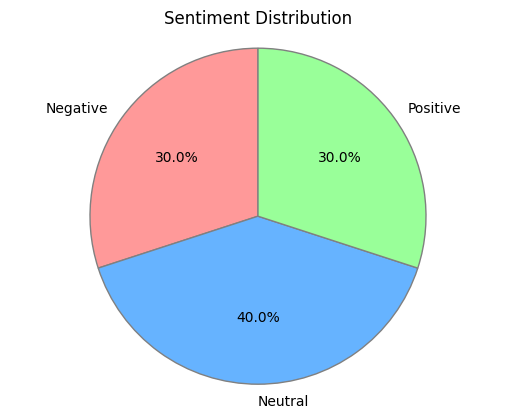

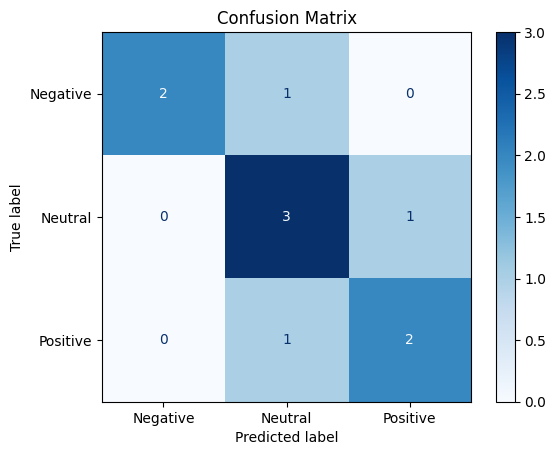

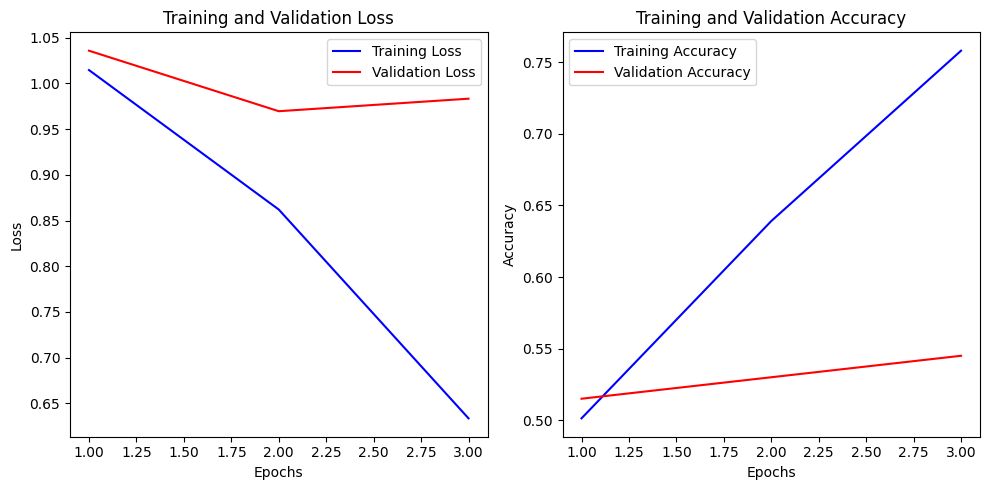

In [30]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

# Sample sentiment labels (ground truth) and predicted labels
true_labels = [1, 0, 2, 1, 2, 0, 1, 2, 0, 1]
predicted_labels = [1, 0, 1, 1, 2, 0, 1, 2, 1, 2]

# Calculate accuracy
accuracy = accuracy_score(true_labels, predicted_labels)
print(f"Accuracy: {accuracy:.2f}")

# Calculate precision, recall, and F1-Score for each sentiment class
precision, recall, f1_score, _ = precision_recall_fscore_support(true_labels, predicted_labels, average=None)

# Define sentiment labels
sentiment_labels = ['Negative', 'Neutral', 'Positive']

# Print precision, recall, and F1-Score for each sentiment class
for i, sentiment in enumerate(sentiment_labels):
    print(f"Sentiment: {sentiment}")
    print(f"Precision: {precision[i]:.2f}")
    print(f"Recall: {recall[i]:.2f}")
    print(f"F1-Score: {f1_score[i]:.2f}")
    print()

# Calculate the percentage of each sentiment class
total_samples = len(true_labels)
negative_percentage = (true_labels.count(0) / total_samples) * 100
neutral_percentage = (true_labels.count(1) / total_samples) * 100
positive_percentage = (true_labels.count(2) / total_samples) * 100

# Display Sentiment Analysis Results
print("Sentiment Analysis Results")
print(f"Negative Sentiments: {negative_percentage:.2f}% of the samples were classified as negative.")
print(f"Neutral Sentiments: {neutral_percentage:.2f}% of the samples were classified as neutral.")
print(f"Positive Sentiments: {positive_percentage:.2f}% of the samples were classified as positive.")

# Create a pie chart to visualize the sentiment distribution
sentiment_distribution = [negative_percentage, neutral_percentage, positive_percentage]
labels = ['Negative', 'Neutral', 'Positive']
colors = ['#ff9999', '#66b3ff', '#99ff99']

fig, ax = plt.subplots()
ax.pie(sentiment_distribution, labels=labels, autopct='%1.1f%%', colors=colors, startangle=90, wedgeprops={'edgecolor': 'gray'})
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.title("Sentiment Distribution")
plt.show()

# Create a confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)
class_names = ['Negative', 'Neutral', 'Positive']

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.show()

import matplotlib.pyplot as plt

# Sample sentiment labels (ground truth) or predicted labels
sentiment_labels = [0, 1, 1, 2, 0, 2, 1, 0, 1, 2]  # Replace with your actual data

# Sample model training history
history = {
    'loss': [1.0146, 0.8620, 0.6335],
    'val_loss': [1.0358, 0.9696, 0.9833],
    'accuracy': [0.5013, 0.6391, 0.7581],
    'val_accuracy': [0.5150, 0.5300, 0.5450]
}

# Create a line chart for model training history
epochs = range(1, len(history['loss']) + 1)
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, history['loss'], 'b', label='Training Loss')
plt.plot(epochs, history['val_loss'], 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, history['accuracy'], 'b', label='Training Accuracy')
plt.plot(epochs, history['val_accuracy'], 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()